Installing AI Magic tools... (Please wait)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.1.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rembg 2.0.72 requires numpy<3.0.0,>=2.3.0, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have nu

Saving input_raw.jpg to input_raw.jpg
Processing input_raw.jpg...
Step 1: Gently removing grain...
Step 2: Correcting exposure gently...
Step 3: AI Face Restoration (Preserving Identity)...
Step 4: Removing background...
Step 5: Creating studio background blur...
Done! Downloading image...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

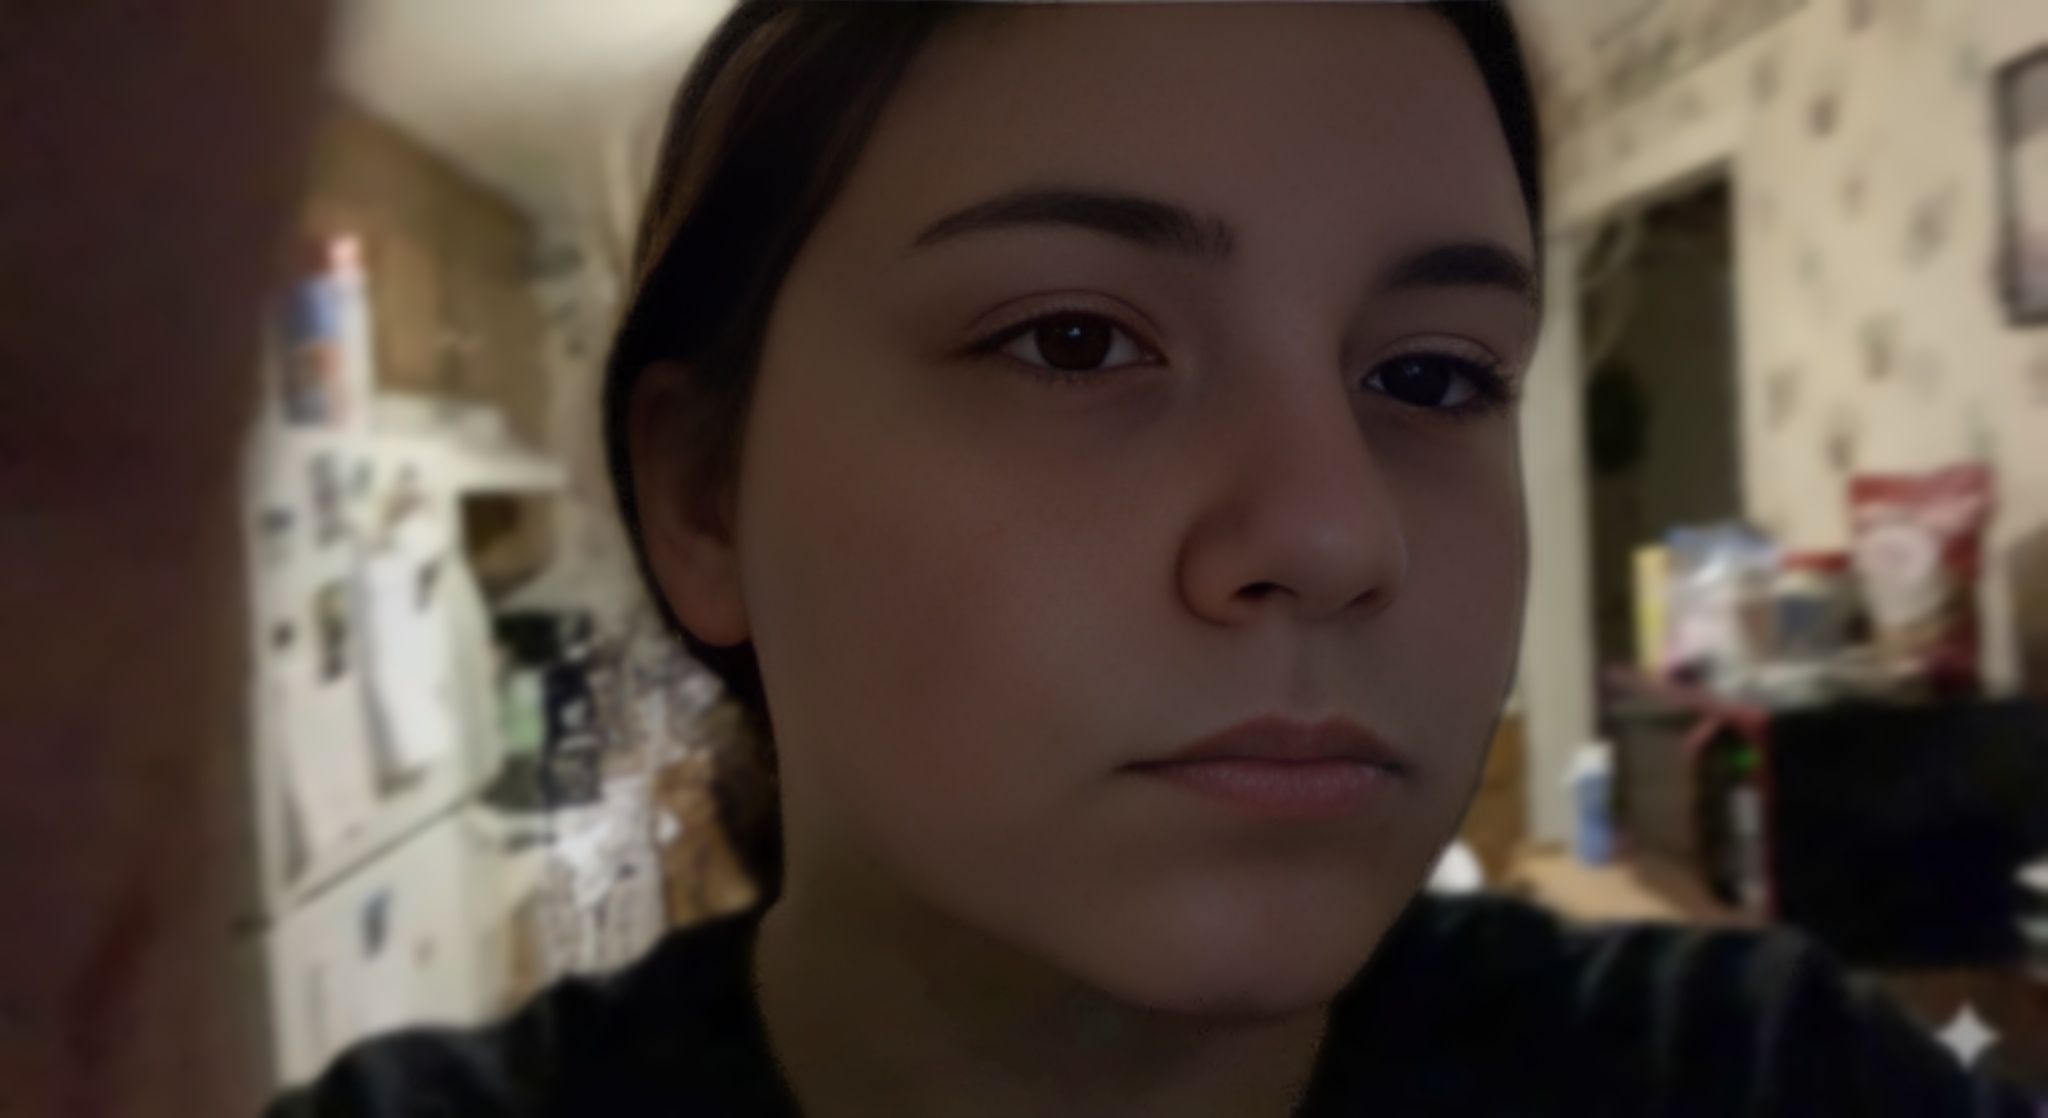

In [2]:
# @title 📸 Final Attempt: Identity-Preserving Studio Fix

# Step 1: Install Tools
print("Installing AI Magic tools... (Please wait)")
!pip install -q rembg gfpgan basicsr onnxruntime-gpu
!pip install -q opencv-python-headless

# Step 1.5: Fix Compatibility Error
import sys
import os
print("Applying library patch...")
!sed -i 's/from torchvision.transforms.functional_tensor import rgb_to_grayscale/from torchvision.transforms.functional import rgb_to_grayscale/g' /usr/local/lib/python*/dist-packages/basicsr/data/degradations.py

import cv2
import numpy as np
import torch
from gfpgan import GFPGANer
from rembg import remove
from google.colab import files
from IPython.display import display, Image

# Step 2: Initialize Models
print("Loading Models...")
# Using clean model for better identity preservation
restorer = GFPGANer(
    model_path='https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth',
    upscale=2,
    arch='clean',
    channel_multiplier=2,
    bg_upsampler=None
)

# Step 3: Upload Image
print("\n--- UPLOAD YOUR ORIGINAL DARK IMAGE BELOW ---")
uploaded = files.upload()
filename = next(iter(uploaded))

# Step 4: The Processing Pipeline
print(f"Processing {filename}...")
input_img = cv2.imread(filename)

# --- STEP A: GENTLE DENOISING (To keep features) ---
print("Step 1: Gently removing grain...")
# Lower strength to preserve facial structure
denoised_img = cv2.fastNlMeansDenoisingColored(input_img, None, 5, 5, 7, 21)

# --- STEP B: MILD BRIGHTENING ---
print("Step 2: Correcting exposure gently...")
# Using Gamma correction which is more natural than simple brightness
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Gamma 1.3 is gentle
bright_img = adjust_gamma(denoised_img, gamma=1.3)

# --- STEP C: AI FACE RESTORATION ---
print("Step 3: AI Face Restoration (Preserving Identity)...")
# The AI now sees the real features and doesn't have to guess
_, _, restored_img = restorer.enhance(bright_img, has_aligned=False, only_center_face=False, paste_back=True)

# --- STEP D: BACKGROUND REMOVAL ---
print("Step 4: Removing background...")
# Now that the image is bright, rembg should work perfectly
subject_no_bg = remove(restored_img)

# --- STEP E: BOKEH BLUR ---
print("Step 5: Creating studio background blur...")
blur_amount = (35, 35) # Heavy blur for studio look
blurred_bg = cv2.GaussianBlur(restored_img, blur_amount, 0)

# --- STEP F: COMPOSITE ---
alpha_channel = subject_no_bg[:, :, 3] / 255.0
alpha_3ch = cv2.merge([alpha_channel, alpha_channel, alpha_channel])
foreground = subject_no_bg[:, :, :3]
background = blurred_bg

# Blend
final_output = (foreground * alpha_3ch + background * (1 - alpha_3ch)).astype(np.uint8)

# Save
output_filename = "studio_final_identity_fix.jpg"
cv2.imwrite(output_filename, final_output)
print("Done! Downloading image...")
files.download(output_filename)
display(Image(output_filename))